In [1]:
import numpy as np
import pickle
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Embedding, Add, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
def image_to_array(path):
    loaded_img = image.load_img(path, target_size=(256,256,3))
    img_array = image.img_to_array(loaded_img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
def cnn_builder():
    cnn_model = EfficientNetB0(include_top=False, weights='imagenet',
                           input_shape= (256,256,3))
    return cnn_model
def image_to_features(img_array):

    features = cnn_builder().predict(img_array)
    return features

In [7]:
Model(inputs=lstm_model.inputs,outputs=[lstm_model.outputs[0],lstm_model.layers[11].output])  

In [3]:
def predict_caption(model,img_encoded):
    cap_len = 15
    model_attention = Model(inputs=model.inputs,outputs=[model.outputs[0],model.layers[11].output])  
    index_file ='word_index_attention_10k.pkl'
    with open(index_file,'rb') as handle:
        word_index = pickle.load(handle)
    inputs_seq = [2]
    endsequence_token = word_index['endsequence']
    list_attention_weights = []
    for i in range(cap_len):
        inputs_seq_model = pad_sequences([inputs_seq],padding='post',maxlen=15)
        y_pre, attention_scores  = model_attention.predict([img_encoded,inputs_seq_model])
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        list_attention_weights.append(attention_weights)
        next_word = y_pre.argmax()
        if next_word == endsequence_token:
            break
        inputs_seq.append(next_word)
    sentence = []
    for number in inputs_seq:
        sentence.append(list(word_index.keys())[list(word_index.values()).index(number)])
    sentence = sentence [1:]
    prediction = ' '.join(word for word in sentence)
    return prediction, list_attention_weights


In [4]:
cap_len = 15
embed_dim = 1024
vocab_size = 10000

In [5]:
def model_builder():
    inputs2  = Input(shape=(cap_len,),name="captions")
    embed_layer = Embedding(vocab_size+1, embed_dim, mask_zero=True)(inputs2)

    input_encoded = Input(shape=(8,8,1280),name="images_encoded")
    features = tf.keras.layers.Reshape((64, input_encoded.shape[-1]))(input_encoded)
    cnn_dense = Dense(embed_dim, activation='relu')(features)

    cnn_socre = tf.keras.layers.Dense(256)(cnn_dense)

    seq_context = LSTM(256)(embed_layer)
    seq_context = tf.expand_dims(seq_context, 1)
    seq_score = tf.keras.layers.Dense(256)(seq_context)

    combine_score = Add()([cnn_socre,seq_score])
    combine_score_activation = tf.nn.tanh(combine_score)

    attention_scores = Dense(1)(combine_score_activation)
    attention_weights = tf.nn.softmax(attention_scores, axis=1)

    heatmaped_image = tf.keras.layers.Multiply()([cnn_dense,attention_weights])
    pooling_heatmaped = tf.keras.layers.GlobalAveragePooling1D()(heatmaped_image)


    combine = Add()([embed_layer,pooling_heatmaped])
    lstm_layer = LSTM(embed_dim)(combine)
    decoder = Dense(2048, activation='relu')(lstm_layer)
    outputs = Dense(vocab_size, activation='softmax')(decoder)
    
    return Model(inputs=[input_encoded, inputs2], outputs=outputs)

In [6]:
lstm_model = model_builder()
lstm_model.load_weights('20220614_attention_caplen25_modelweights.h5')

2022-06-16 13:25:33.933693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:25:33.949756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:25:33.950414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 13:25:33.951909: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:


img_array = image_to_array('a11istockphoto-1086632014-612x612.jpeg')
img_encoded = image_to_features(img_array)
caption,attention_weights = predict_caption(lstm_model, img_encoded)
print(caption)

man in a black sweater is holding a can that says time


In [12]:
from PIL import Image

result = caption.split()

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_attention(image, result, attention_plot):
    temp_image = image

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

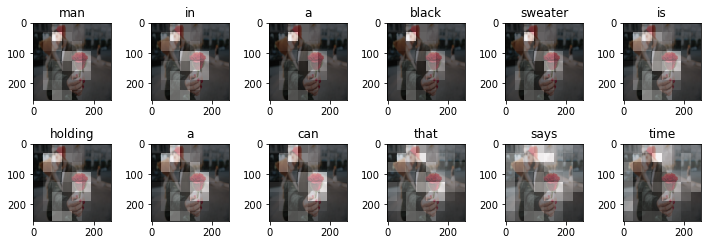

In [15]:
plot_attention(img_array[0]/255, result, attention_weights)

In [46]:
def plot_attention_idx(image, result, attention_plot,index):
    temp_image = image

    fig = plt.figure(figsize=(10, 10))
    temp_att = np.resize(attention_plot[index], (8, 8))

    plt.title(result[index])
    img = plt.imshow(temp_image)
    plt.imshow(temp_att,cmap='bwr', alpha=0.3, extent=img.get_extent())
    
    plt.savefig('attention_layer_rose.jpeg')
    plt.show()

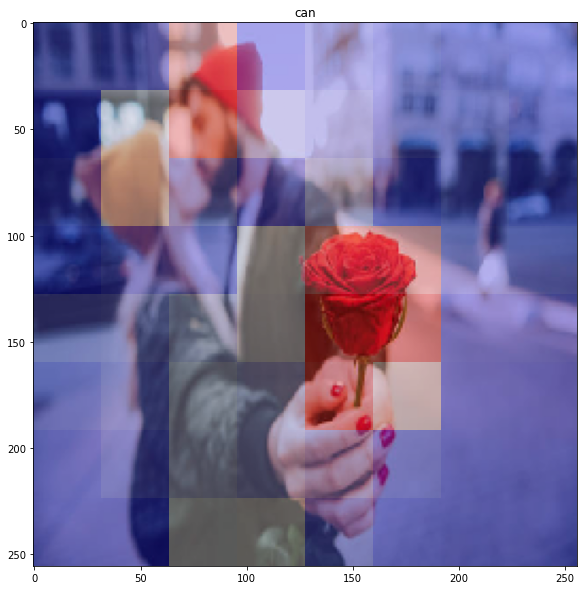

In [47]:
plot_attention_idx(img_array[0]/255, result, attention_weights,8)

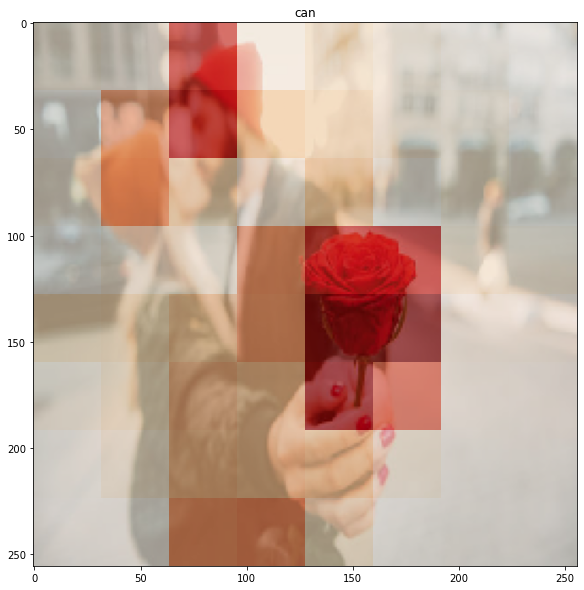

In [37]:
plot_attention_idx(img_array[0]/255, result, attention_weights,8)

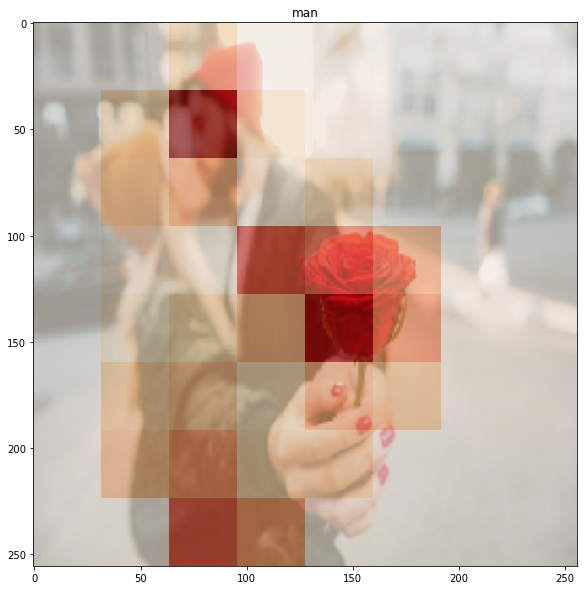

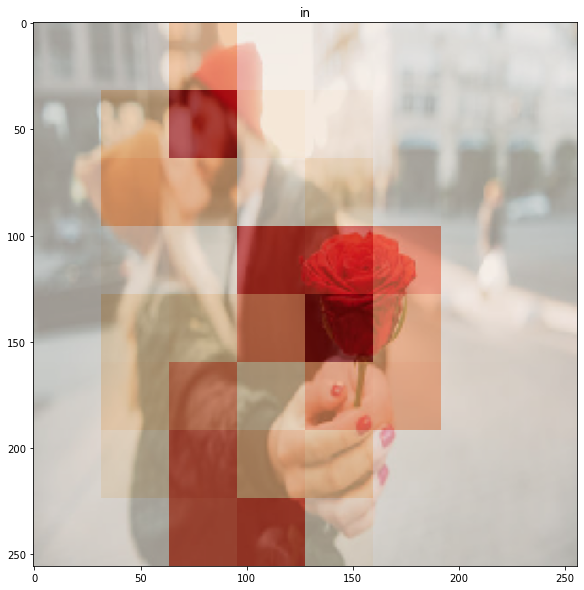

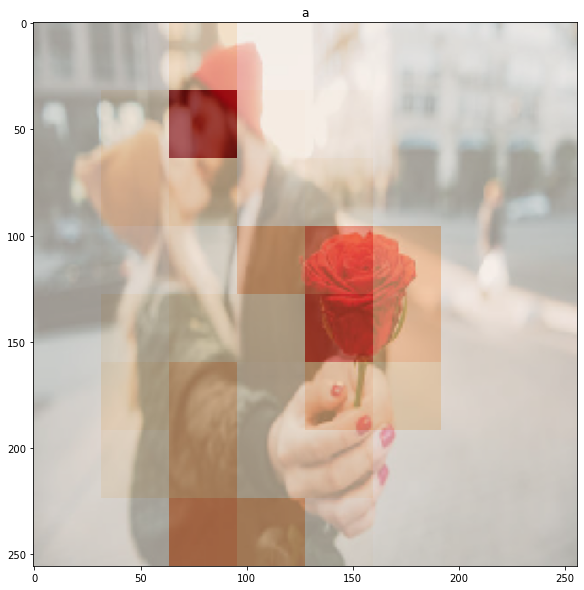

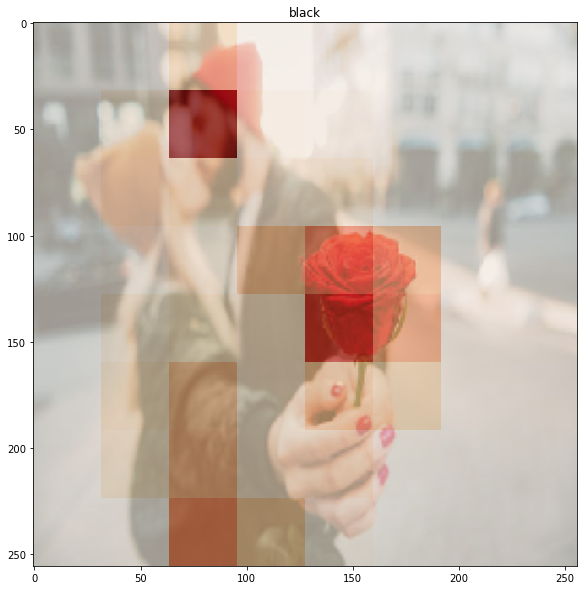

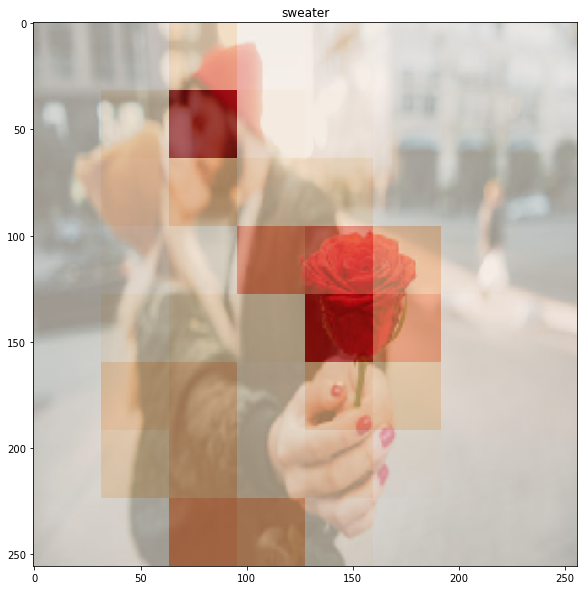

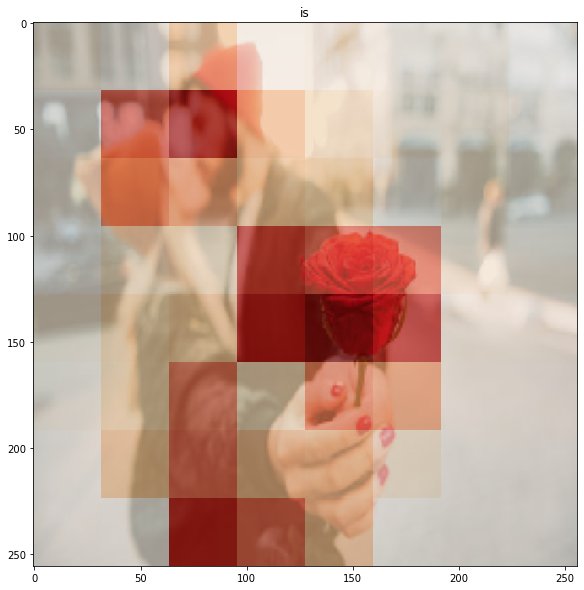

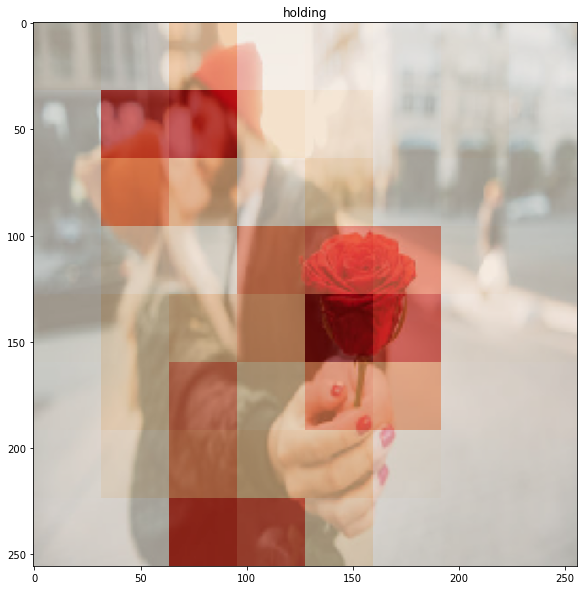

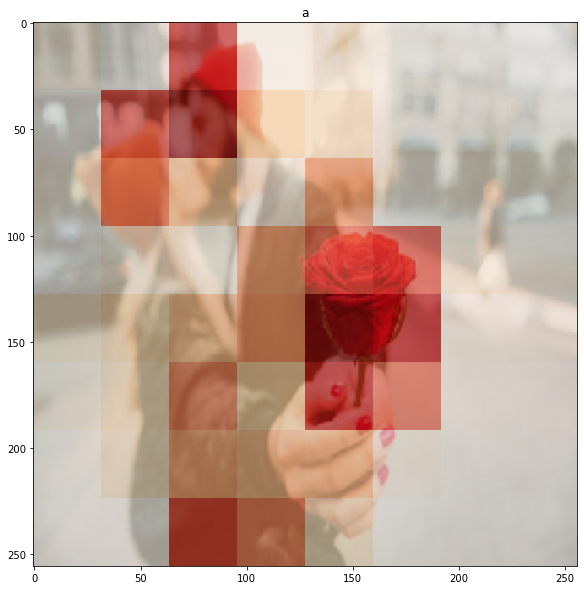

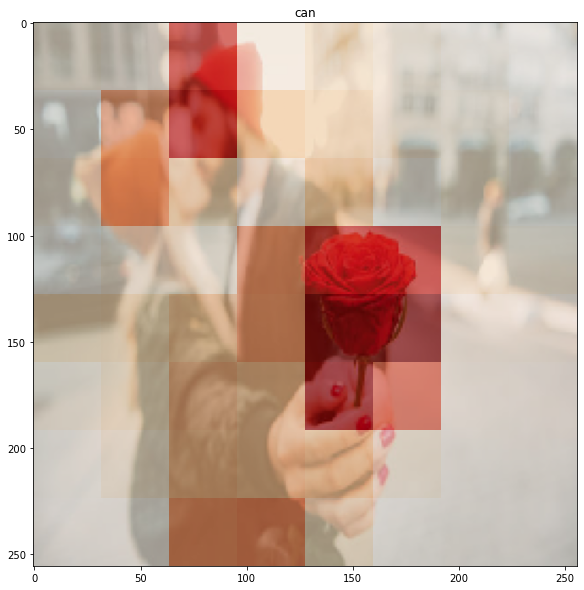

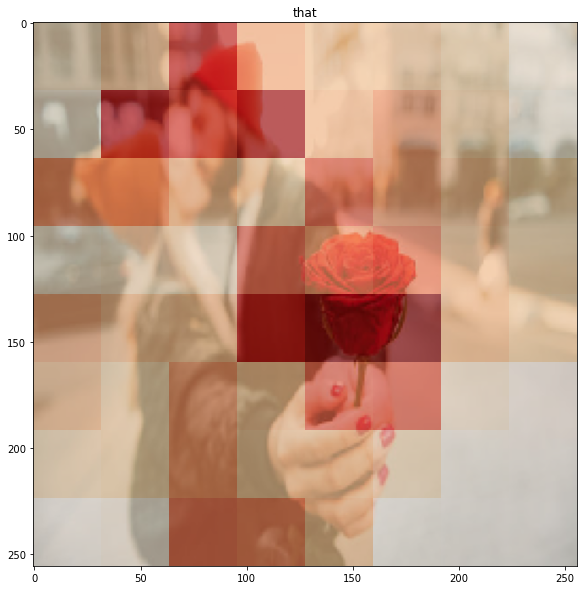

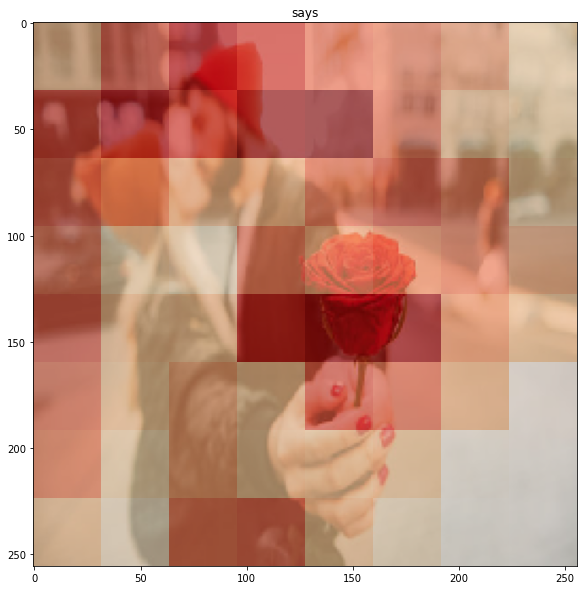

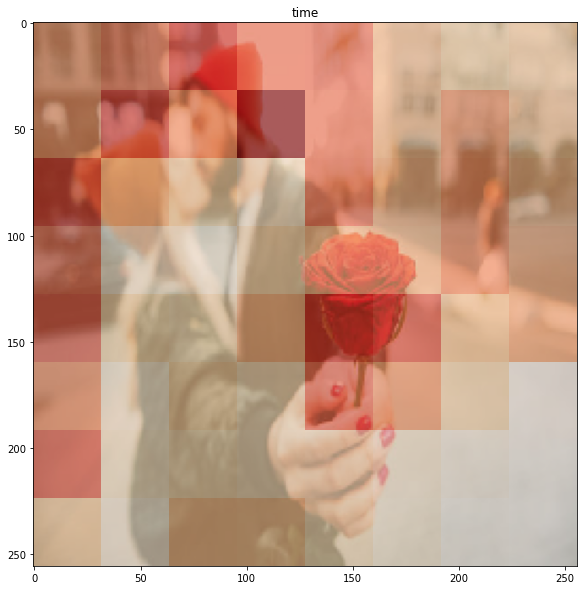

In [31]:
for i in range(len(result)):
    plot_attention_idx(img_array[0]/255, result, attention_weights,i)